In [25]:
import os
import sys

path = os.getcwd()
par_path = os.path.abspath(os.pardir)
sys.path.append(par_path)

import medmnist
from medmnist import INFO

import importlib
import moment_kernels as mk
importlib.reload(mk)

import torch
import torch.nn as tnn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms

import e2cnn.nn as enn
import e2cnn.gspaces as gspaces

from torcheval.metrics.functional import multiclass_confusion_matrix
import seaborn as sns
from torchmetrics.classification import ROC

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import json

# located in /rotnet/benchmark/benchmark_models.py
from benchmark.benchmark_models import *

## **Hyperparameters**

In [2]:
# hyperparameters
EPOCHS = 20
BATCH_SIZE = 128
lr = 0.001
num_layers = 5

## **Dataset**

In [3]:
data_flag = "bloodmnist" #'organamnist' 'dermamnist', 'pathmnist'
download = False
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
run = 0

## **Transforms**

In [4]:
# transforms to convert from image to normalized tensor (or more if augmentation)
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5]),
])

# separate transforms for test
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

## **Splitting and Shuffling**

In [5]:
train_dataset = DataClass(split = "train", transform = train_transforms, download = download)
valid_dataset = DataClass(split = "val", transform = test_transforms, download = download)
test_dataset = DataClass(split = "test", transform = test_transforms, download = download)

train_loader = data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = False)
valid_loader = data.DataLoader(dataset = valid_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

## **Models**

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
models = {
    'VanillaCNN' : {'model' : VanillaCNN(img_channels = 3, n0 = 32, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers).to(device)},
    'TrivialECNN' : {'model' : TrivialECNN(img_channels = 3, n0 = 67, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers).to(device)},
    #'TrivialIrrepECNN' : {'model' : TrivialIrrepECNN(img_channels = 3, n0 = 62, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers).to(device)},
    'RegularECNN' : {'model' : RegularECNN(img_channels = 3, n0 = 29, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers).to(device)},
    'TrivialMoment' : {'model' : TrivialMoment(img_channels = 3, n0 = 55, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers).to(device)},
    #'TrivialIrrepMoment' : {'model' : TrivialIrrepMoment(img_channels = 3, n0 = 59, n_classes = n_classes, kernel_size = 3, padding = 1, num_layers = num_layers).to(device)},
}

/nafs/dtward/intelpython3/lib/python3.9/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


In [8]:
# add the metrics to the models dictionary
for model in models:
    models[model]['metrics'] = json.load(open(os.path.join(path, f"run{run}", 'benchmark', f"metrics_{model}_{data_flag}{run}.json"), "r"))
    models[model]['num_params'] = count_parameters(models[model]['model'])
    models[model]['n_channels'] = models[model]['model'].stages[1]
    models[model]['n_layers'] = models[model]['model'].num_layers

## **Visualization**

### **Parameters/Structure**

In [9]:
parameter_table = pd.DataFrame(columns = ['Model', 'Parameters', 'Channels', 'N Layers'])
for model_name, model_dict in models.items():
    model = model_dict['model']
    parameter_table.loc[len(parameter_table)] = [model_name, model_dict['num_params'], model_dict['n_channels'], model_dict['n_layers']]

parameter_table

,Model,Parameters,Channels,N Layers
0,VanillaCNN,1574151,32,5
1,TrivialECNN,1540404,67,5
2,RegularECNN,1500090,29,5
3,TrivialMoment,1554527,55,5


### **Loss**

In [10]:
plt.style.use('ggplot')

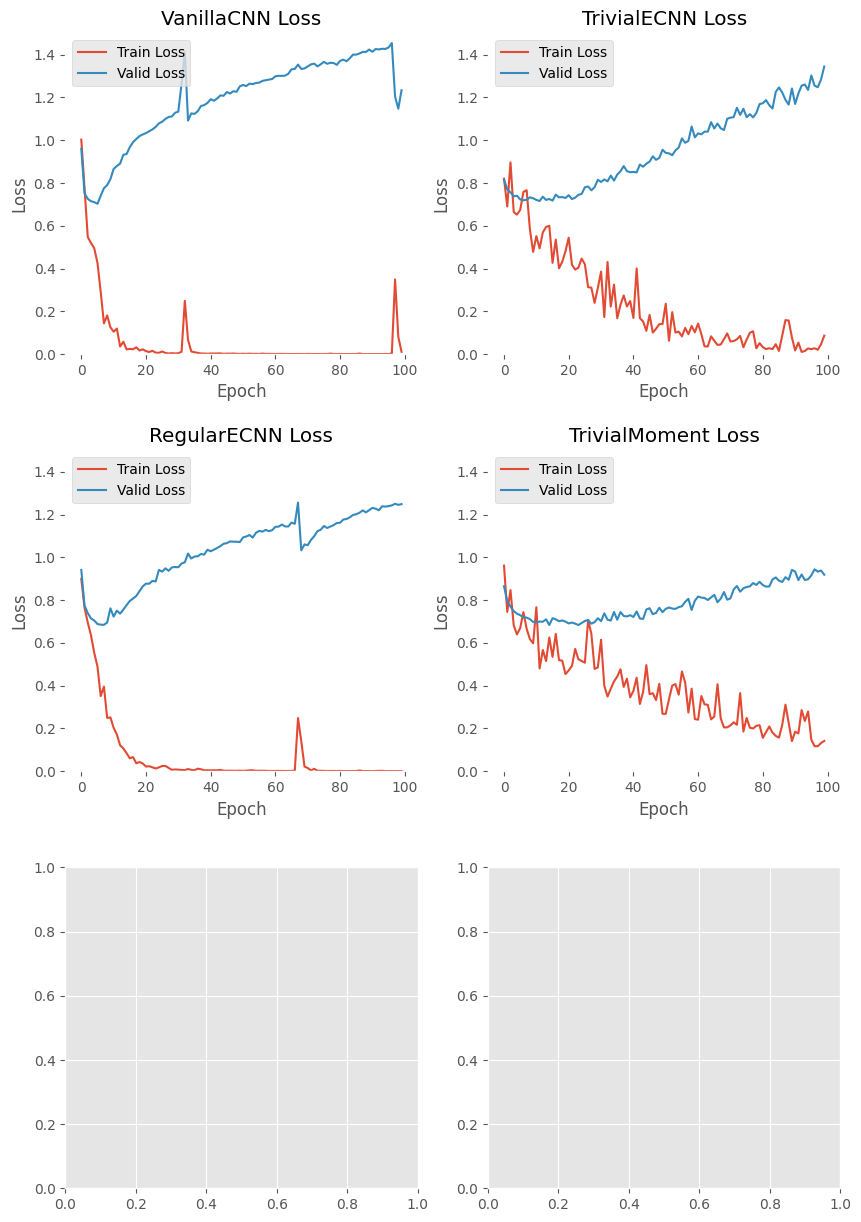

In [11]:
n_rows, n_cols = 3, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize = (10, 15))
fig.subplots_adjust(hspace = 0.3)

for i, model in enumerate(models):
    ax = axes[i // n_cols, i % n_cols]
    ax.plot(models[model]['metrics']['train_losses'], label = 'Train Loss')
    ax.plot(models[model]['metrics']['valid_losses'], label = 'Valid Loss')
    ax.set_title(f"{model} Loss")
    ax.set_ylim(0, 1.5)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.patch.set_facecolor('white') 
    ax.legend(loc='upper left')

### **AUC/Acc**

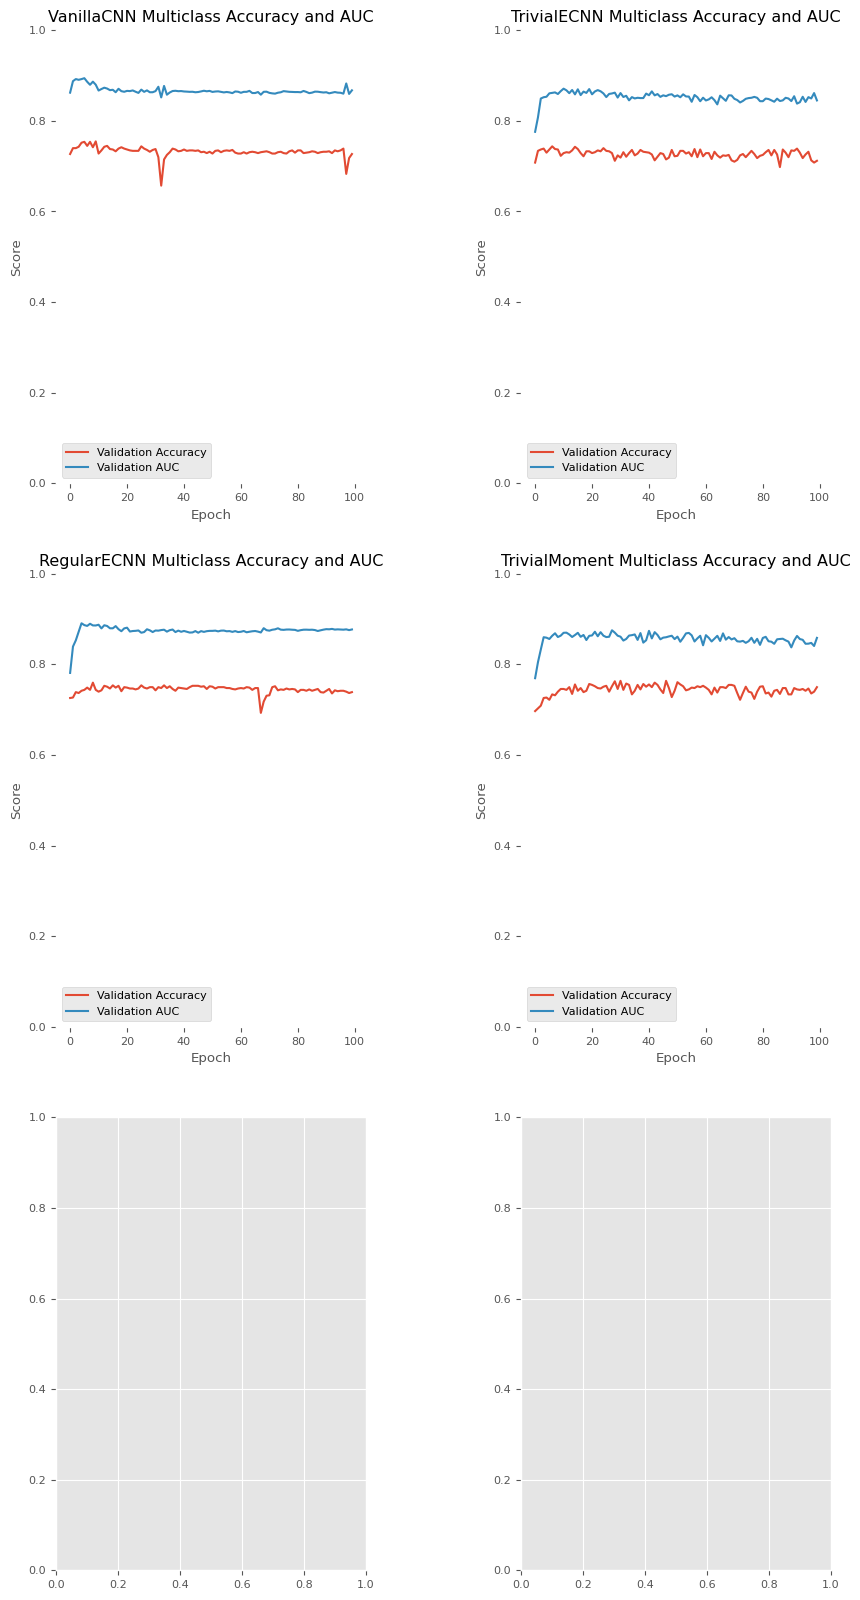

In [73]:
n_rows, n_cols = 3, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize = (10, 20))
fig.subplots_adjust(hspace = 0.2, wspace = 0.5)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 8})

for i, model in enumerate(models):
    # Accuracy
    ax = axes[i // n_cols, i % n_cols]
    ax.plot(models[model]['metrics']['valid_accuracies'], label = 'Validation Accuracy')

    # AUCROC
    ax.plot(models[model]['metrics']['valid_AUCROC'], label = 'Validation AUC')

    # other
    ax.set_title(f"{model} Multiclass Accuracy and AUC")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.patch.set_facecolor('white') 
    ax.set_ylim(0, 1)

    ax.legend(loc='lower left')

### **Timing**

In [13]:
times_table = pd.DataFrame(columns = ['Model', 'Mean Epoch Time'])

for model_name, model_dict in models.items():
    model = model_dict['model']
    times_table.loc[len(times_table)] = [model_name, np.mean(model_dict['metrics']['epoch_times'])]

times_table

,Model,Mean Epoch Time
0,VanillaCNN,102.102372
1,TrivialECNN,93.630922
2,RegularECNN,6.733961
3,TrivialMoment,163.084656


### **Sample Confusion Matrix**

In [74]:
model_name = 'TrivialMoment' #'TrivialIrrepMoment', 'TrivialECNN', 'TrivialIrrepECNN', 'RegularECNN', 'VanillaCNN'
metric = 'best_acc' #'best_auc'
model = models[model_name]['model']
model.load_state_dict(torch.load(os.path.join(path, 'benchmark', f"{metric}_{model_name}_{data_flag}0.pt")))
model = model.eval()

In [85]:
targets = []
predictions = []

for i, sample_batch in enumerate(test_loader):
    sample_images = sample_batch[0].to(device)
    labels = sample_batch[1].to(device)

    prediction = model(sample_images)
    prediction = F.softmax(prediction, dim = 1)
    prediction = torch.argmax(prediction, dim = 1)

    targets.extend(labels.squeeze())
    predictions.extend(prediction)

targets = torch.stack(targets)
predictions = torch.stack(predictions)

cm = multiclass_confusion_matrix(targets, predictions, n_classes).cpu().numpy()

<Axes: title={'center': 'Confusion Matrix for TrivialMoment on dermamnist Test Set (n = 2005)'}>

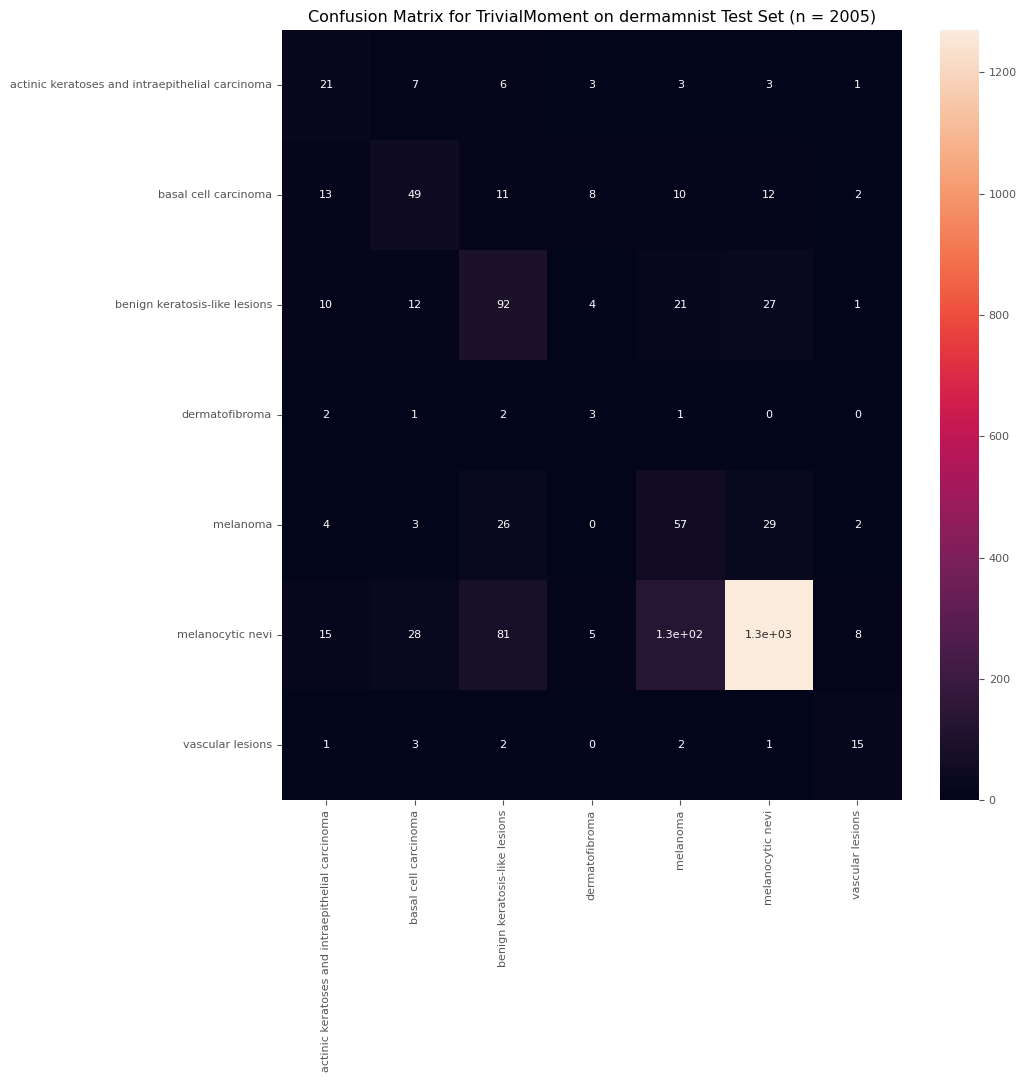

In [86]:
labels = info['label'].values()
plt.figure(figsize = (10, 10))
plt.title(f"Confusion Matrix for {model_name} on {data_flag} Test Set (n = {len(test_dataset)})")
sns.heatmap(cm, annot = True, xticklabels=labels, yticklabels=labels)

### **ROC**

In [87]:
targets = []
predictions = []

for i, sample_batch in enumerate(test_loader):
    sample_images = sample_batch[0].to(device)
    labels = sample_batch[1].to(device)

    prediction = model(sample_images)
    prediction = F.softmax(prediction, dim = 1)

    targets.extend(labels.squeeze())
    predictions.extend(prediction)

targets = torch.stack(targets)
predictions = torch.stack(predictions)

roc = ROC(task = 'multiclass', num_classes = n_classes)
roc.update(predictions, targets)

fpr, tpr, thresholds = roc.compute()

In [88]:
plt.style.use('ggplot')

Text(0.5, 1.0, 'ROC Curve (One-vs-Rest) for TrivialMoment on dermamnist Test Set (n = 2005)')

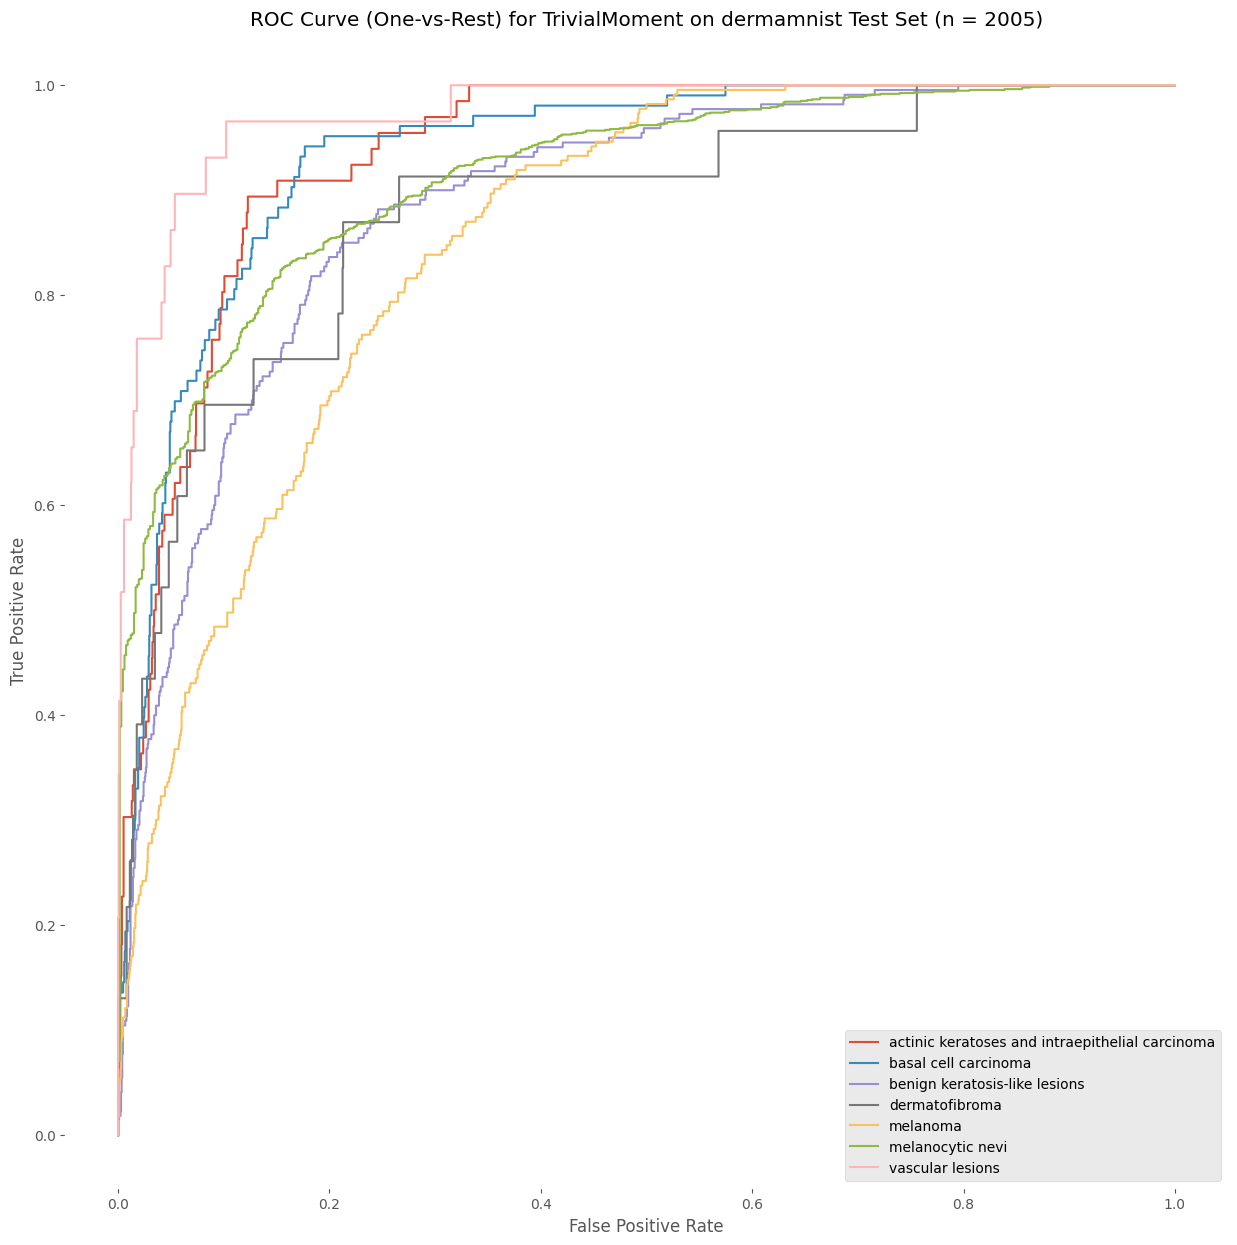

In [89]:
plt.figure(figsize = (15, 15))

for i in range(n_classes):
    plt.plot(fpr[i].cpu().numpy(), tpr[i].cpu().numpy(), label = f"{info['label'][str(i)]}")

plt.gca().patch.set_facecolor('white')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f"ROC Curve (One-vs-Rest) for {model_name} on {data_flag} Test Set (n = {len(test_dataset)})")